In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import mrpro

/home/lunin01/miniforge3/envs/pytorch312/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import torch

In [23]:
def proc_cpu(dataset_file, smooth_width=1):
    # reading the k-space data
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    # evaluate for each slice in slices
    sl_list = [mrpro.algorithms.csm.walsh(sl, smooth_width) for sl in torch.unbind(image_space, 0)]
    # sensitivity maps for each slices (slices, coils, 1, height, width)
    sens_maps = torch.stack(sl_list, dim=0)
    # see mrpro.operators.SensitivityOp
    # applying the sensitivity maps to the image_space images
    # sum over coils and "1" dimension to obtain the normalized images
    # of shape (slices, height, width)
    return torch.sum(sens_maps.conj()*image_space, dim=(1,2))

In [29]:
def proc_gpu(dataset_file, smooth_width=1):
    # reading the k-space data
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    k_space = k_space.to(device="cuda")
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    # evaluate for each slice in slices
    sl_list = [mrpro.algorithms.csm.walsh(sl, smooth_width) for sl in torch.unbind(image_space, 0)]
    # sensitivity maps for each slices (slices, coils, 1, height, width)
    sens_maps = torch.stack(sl_list, dim=0)
    # see mrpro.operators.SensitivityOp
    # applying the sensitivity maps to the image_space images
    # sum over coils and "1" dimension to obtain the normalized images
    # of shape (slices, height, width)
    return torch.sum(sens_maps.conj()*image_space, dim=(1,2)).to(device="cpu")

In [103]:
def save_ind_fts(dataset_file):
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    f = plt.figure()
    ax = f.gca()
    for i, coil in enumerate(image_space[2]):
        g = min(coil[0].shape)
        crop = lambda x: center_crop(x, output_size=(g,g))
        ax.imshow(crop(coil[0].abs()), cmap='gray')
        ax.axis('off')
        f.savefig('coil_%d.png' % i, dpi=400, bbox_inches='tight', transparent=True)

In [118]:
def save_smaps(dataset_file):
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    smooth_width =1
    sl_list = [mrpro.algorithms.csm.walsh(sl, smooth_width) for sl in torch.unbind(image_space, 0)]
    f = plt.figure()
    ax = f.gca()
    for i, coil in enumerate(sl_list[2]):
        g = min(coil[0].shape)
        crop = lambda x: center_crop(x, output_size=(g,g))
        ax.imshow(crop(coil[0].abs()), cmap='gray')
        ax.axis('off')
        f.savefig('sm_%d.png' % i, dpi=400, bbox_inches='tight', transparent=True)

In [114]:
def save_k_space(dataset_file):
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    f = plt.figure()
    ax = f.gca()
    for i, coil in enumerate(k_space[2]):
        g = min(coil[0].shape)
        crop = lambda x: center_crop(x, output_size=(200,200))
        ax.imshow(crop(coil[0].abs()), cmap='gray', norm='log', interpolation='none')
        ax.axis('off')
        f.savefig('coil_k_space_%d.png' % i, dpi=400, bbox_inches='tight', transparent=True)

In [7]:
%matplotlib widget

In [8]:
import h5py

In [9]:
import os

In [10]:
from torch import Tensor

In [11]:
import torchvision.transforms

In [12]:
from torchvision.transforms.functional import center_crop 

In [13]:
base_path = "files_h5/h5_to_transfer"
raw_path = "files_h5/h5_to_transfer/raw/"
proc_path = "files_h5/h5_to_transfer/proc/"

In [14]:
file_list = os.listdir(os.path.join(base_path, "raw"))

In [15]:
file_list

['file_brain_AXT2_208_2080386.h5',
 'file_brain_AXT1POST_207_2070481.h5',
 'file_brain_AXT2_209_6001382.h5',
 'file_brain_AXT1POST_205_2050026.h5',
 'file_brain_AXT1POST_208_2080328.h5',
 'file_brain_AXT1POST_208_2080023.h5']

In [16]:
def get_raw(filename):
    return Tensor(h5py.File(os.path.join(raw_path, filename))["reconstruction_rss"][:])

In [17]:
def get_proc(filename):
    return Tensor(h5py.File(os.path.join(proc_path, filename))["reconstruction_smap"][:])

In [36]:
proc_cpu_files = []
proc_gpu_files = []
for file in file_list:
    proc_cpu_files.append(proc_cpu(h5py.File(os.path.join(raw_path, file))))
    proc_gpu_files.append(proc_gpu(h5py.File(os.path.join(raw_path, file))))

In [ ]:
len(proc_cpu_files)

KeyboardInterrupt: 

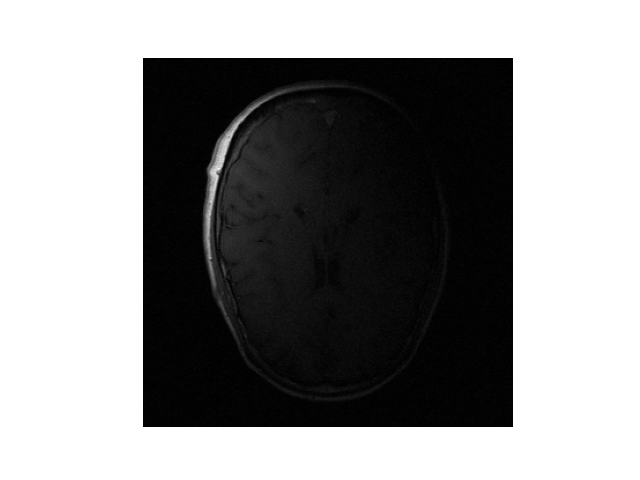

In [108]:
save_ind_fts(h5py.File(os.path.join(raw_path, 'file_brain_AXT1POST_205_2050026.h5') ))

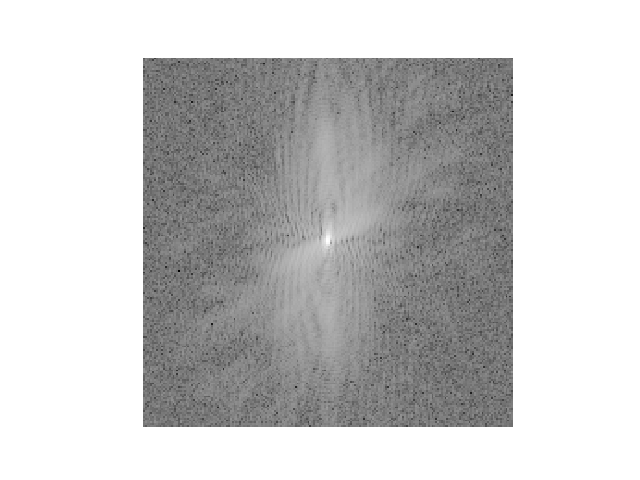

In [115]:
save_k_space(h5py.File(os.path.join(raw_path, 'file_brain_AXT1POST_205_2050026.h5') ))

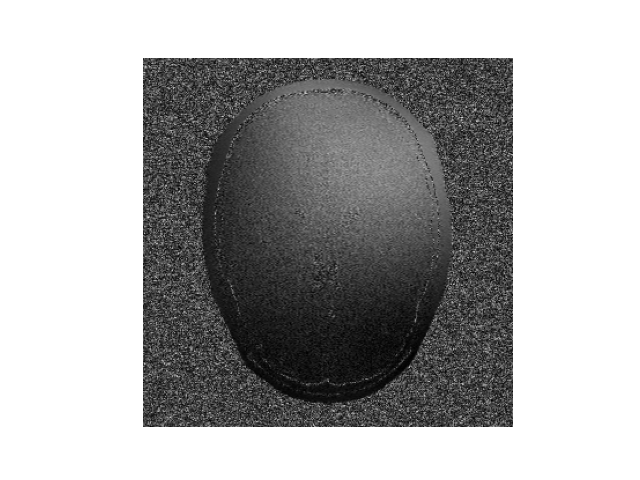

In [119]:
save_smaps(h5py.File(os.path.join(raw_path, 'file_brain_AXT1POST_205_2050026.h5') ))

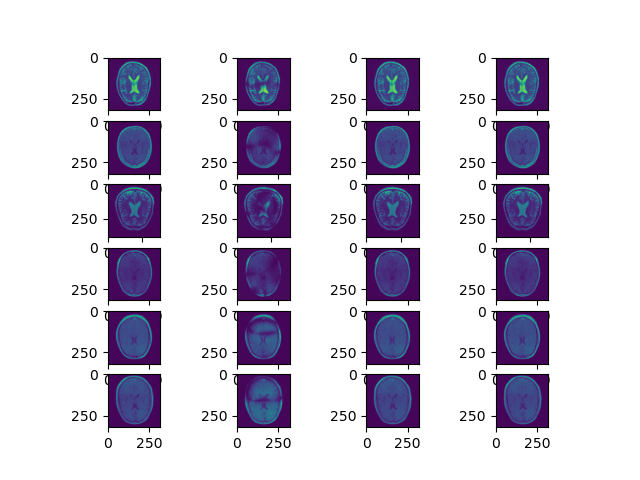

In [43]:
f = plt.figure()
axs = f.subplots(6, 4)
for i, (ax_line, file) in enumerate(zip(axs, file_list)):
    raw = get_raw(file)
    shape = raw[2].shape
    proc = get_proc(file)
    crop = lambda x: center_crop(x, output_size=shape)
    ax_line[0].imshow(raw[2].abs())
    ax_line[1].imshow(crop(proc[2].abs()))
    ax_line[2].imshow(crop(proc_cpu_files[i][2].abs()))
    ax_line[3].imshow(crop(proc_gpu_files[i][2].abs()))

/home/lrlunin/miniforge3/envs/pytorch312/lib/python3.12/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


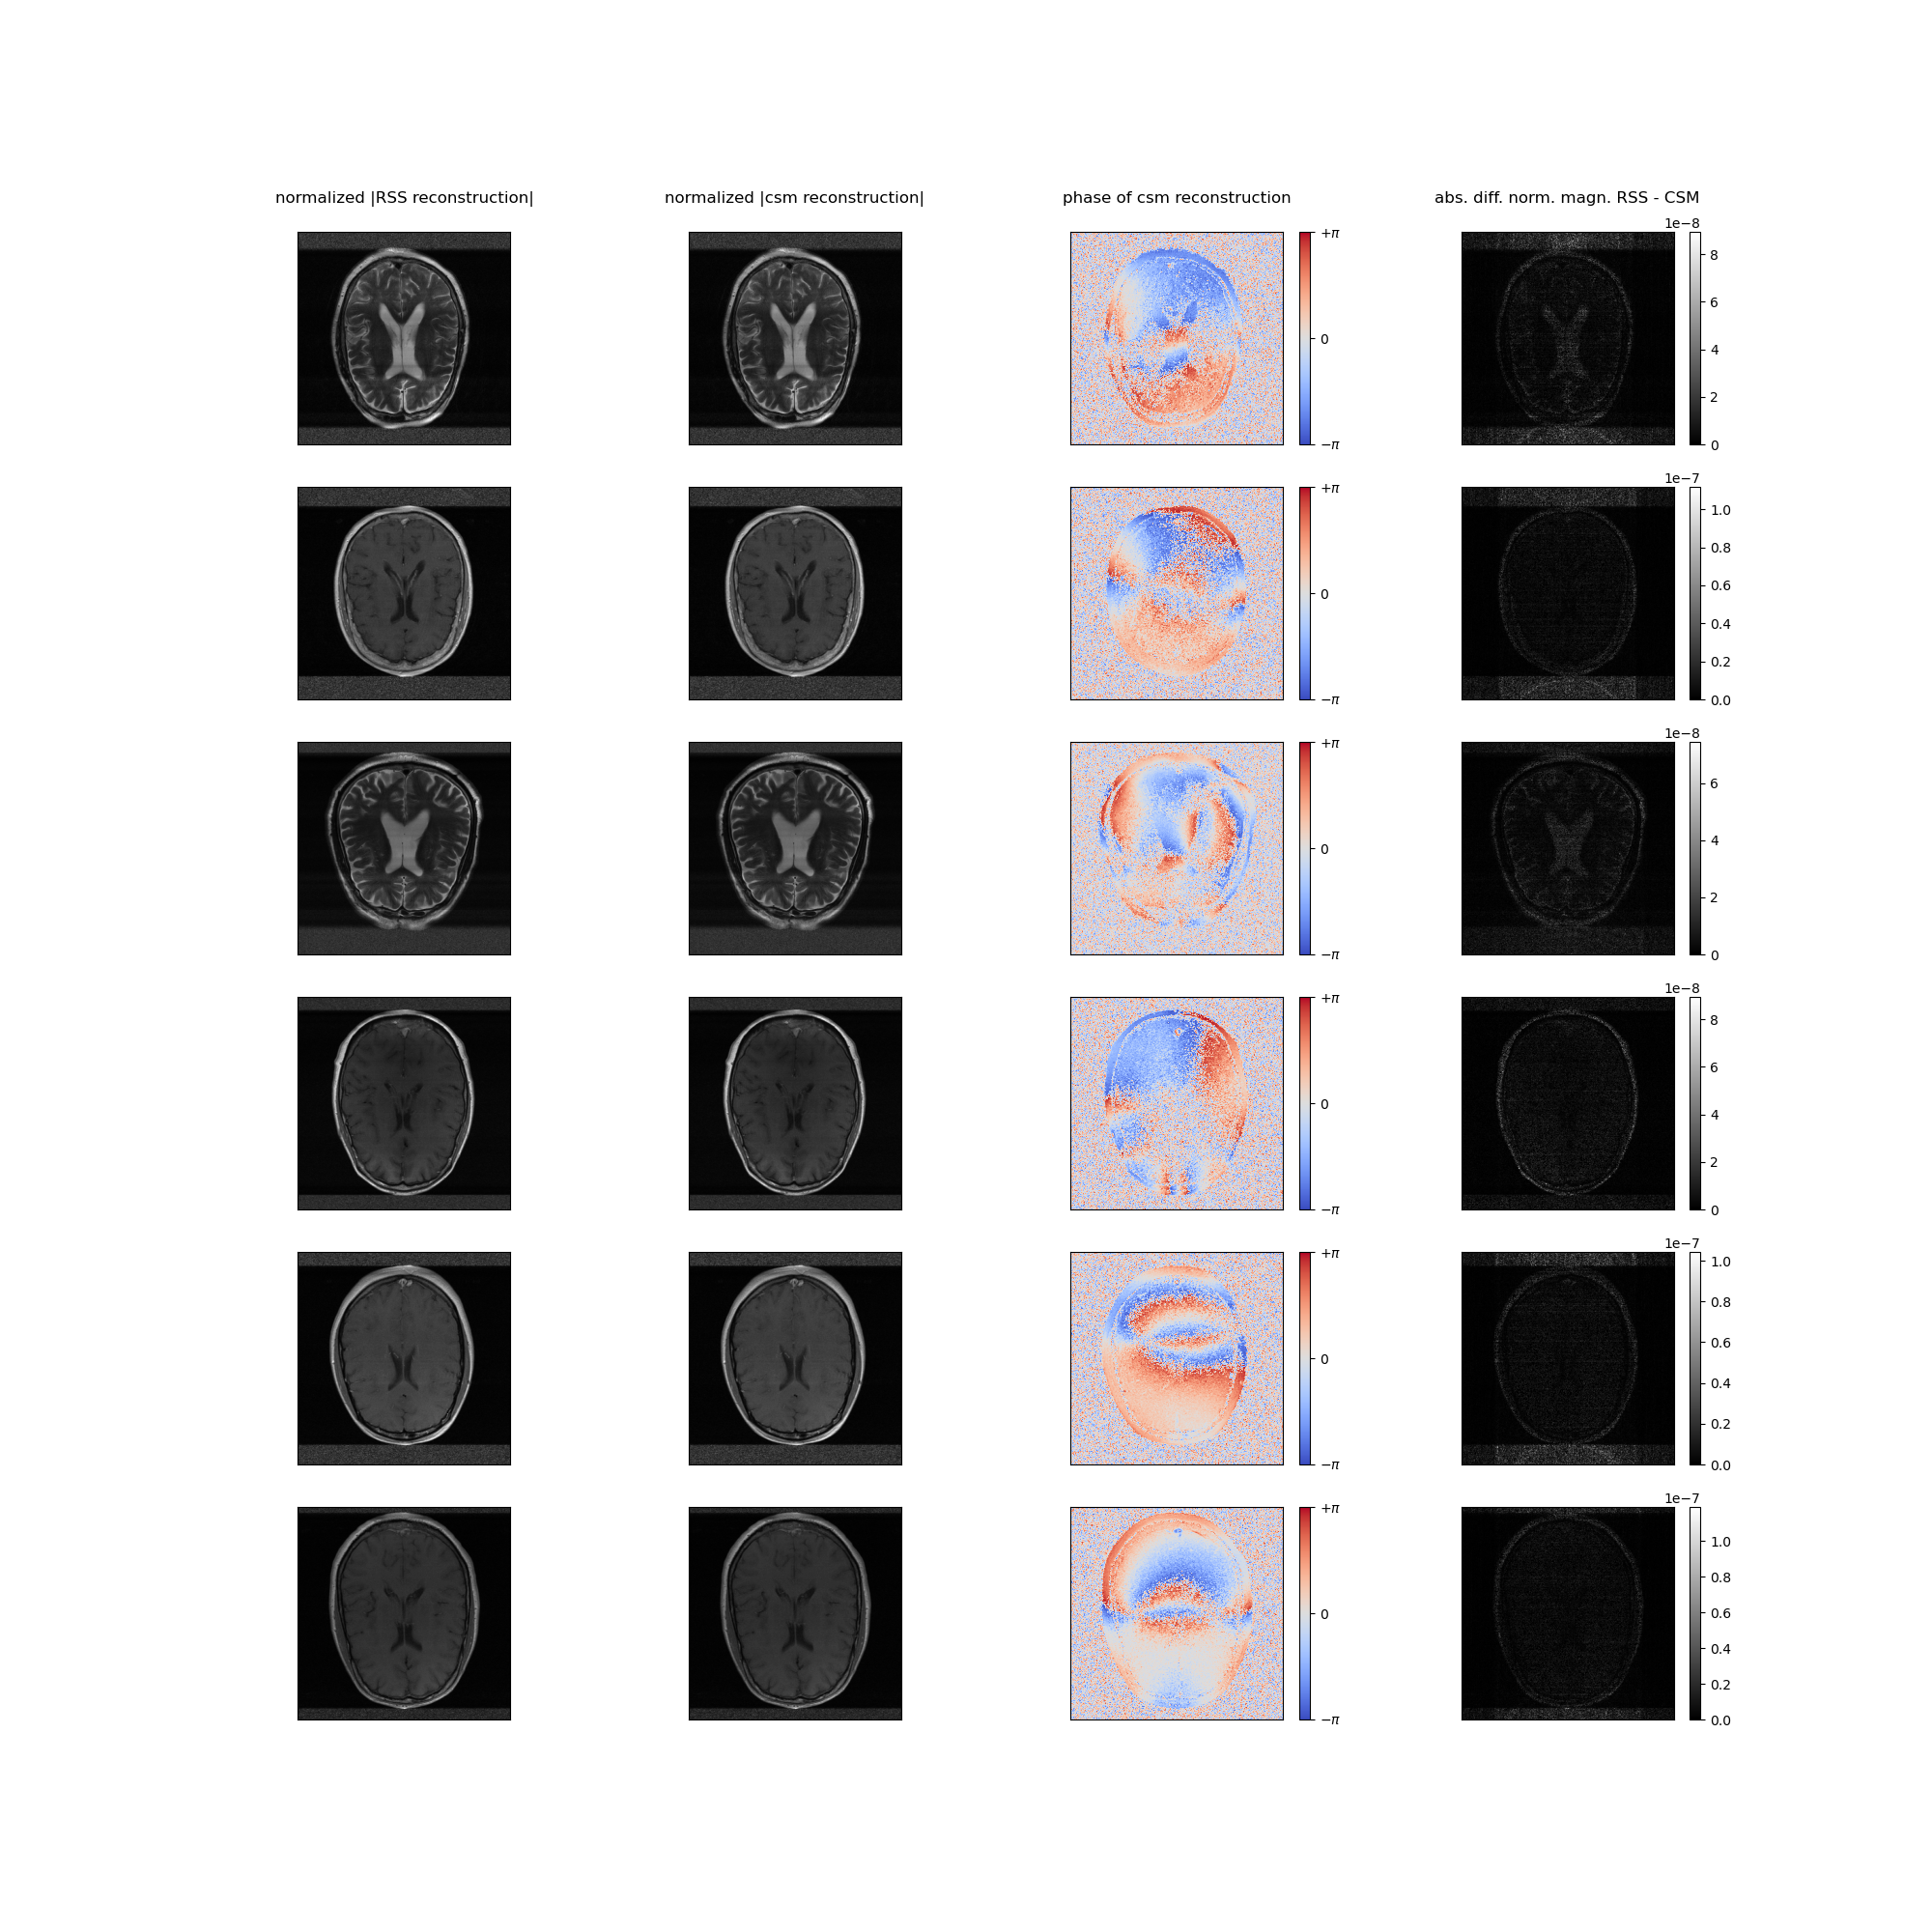

In [125]:
f = plt.figure(figsize=(20, 20))
axs = f.subplots(6, 4)
for i, (ax_line, file) in enumerate(zip(axs, file_list)):
    raw = get_raw(file)
    shape = raw[2].shape
    crop = lambda x: center_crop(x, output_size=shape)
    cmap_reconst = crop(proc_cpu_files[i][2])

    norm_rss = torch.nn.functional.normalize(raw[2].abs())
    norm_csm = torch.nn.functional.normalize(cmap_reconst.abs())    
    
    ax_line[0].imshow(norm_rss, cmap='gray')
    ax_line[1].imshow(norm_csm, cmap='gray')
    
    eps = 1e-3
    im = ax_line[2].imshow((cmap_reconst.angle() % 2*np.pi) - np.pi, cmap='coolwarm', vmin=-np.pi - eps, vmax=np.pi + eps)
    cbar = plt.colorbar(im, ax=ax_line[2], ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels(["$-\\pi$", "0", "$+\\pi$"])
    
    [ax.set_xticks([]) for ax in ax_line]
    [ax.set_yticks([]) for ax in ax_line]
    
    im2 = ax_line[3].imshow((norm_rss - norm_csm).abs(), cmap='gray')
    plt.colorbar(im2, ax=ax_line[3])
    if i == 0:
        y_pos = 1.1
        ax_line[0].set_title("normalized |RSS reconstruction|", y=y_pos)
        ax_line[1].set_title("normalized |csm reconstruction|", y=y_pos)
        ax_line[2].set_title("phase of csm reconstruction", y=y_pos)
        ax_line[3].set_title("abs. diff. norm. magn. RSS - CSM", y=y_pos)
f.savefig('complex_recons.svg')

In [26]:
nx.nxload(os.path.join(proc_path, "file_brain_AXT1POST_205_2050026.h5")).tree

'root:NXroot\n  kspace = complex64(16x16x640x320)\n  reconstruction_smap = complex64(16x640x320)'